In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

 |         |                     |
 |---------|---------------------|
 |client_id|идентификатор клиента|
 |education	|уровень образования|
 |sex	|пол заёмщика|
 |age	|возраст заёмщика|
 |car|	флаг наличия автомобиля|
 |car_type|	флаг автомобиля-иномарки|
 |decline_app_cnt|	количество отказанных прошлых заявок|
 |good_work|	флаг наличия «хорошей» работы|
 |bki_request_cnt|	количество запросов в БКИ|
 |home_address|	категоризатор домашнего адреса|
 |work_address|	категоризатор рабочего адреса|
 |income|	доход заёмщика|
 |foreign_passport|	наличие загранпаспорта|
 |default|	наличие дефолта|

In [3]:
data = pd.read_csv('./Project_4_data/train.csv')

#data.drop(columns='client_id',inplace=True)

In [4]:
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,63161,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,25887,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0
3,16222,SCH,F,53,N,N,0,0,2,2,3,10000,N,0
4,101655,GRD,M,48,N,N,0,1,1,2,3,30000,Y,0


In [5]:
# data.info()

In [139]:
data.default.value_counts()/data.default.value_counts()[1]

0    6.874413
1    1.000000
Name: default, dtype: float64

C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


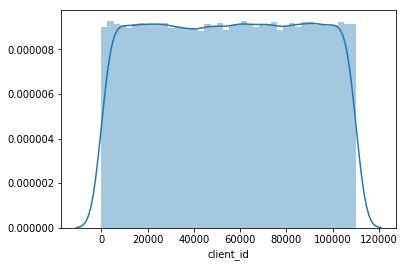

In [6]:
sns.distplot(data.client_id)

In [50]:
data.columns

Index(['client_id', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'bki_request_cnt', 'home_address',
       'work_address', 'income', 'foreign_passport', 'default'],
      dtype='object')

C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


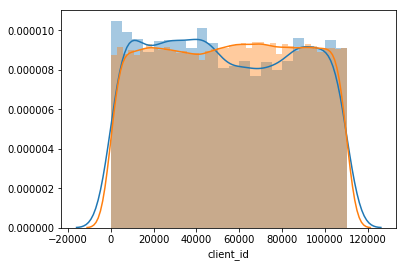

In [72]:
sns.distplot(data.loc[data.foreign_passport=='Y'].client_id)
sns.distplot(data.loc[data.foreign_passport=='N'].client_id)

C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


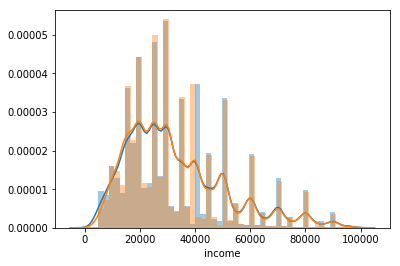

In [80]:
# plt.xscale('log')
sns.distplot(data.income[data.client_id<65000][data.income<100000])
sns.distplot(data.income[data.client_id>65000][data.income<100000])

In [68]:
categories

array(['Y', 'N'], dtype=object)

In [48]:
# разделим на типы признаков
num_uniq = data.drop(columns='default').nunique()

bin_cols = data.drop(columns='default').columns[num_uniq==2]
cat_cols = data.drop(columns='default').columns[(num_uniq>2) & (num_uniq<7)] 
num_cols = data.drop(columns='default').columns[num_uniq>6]

In [67]:
bin_cols

Index(['sex', 'car', 'car_type', 'good_work', 'foreign_passport'], dtype='object')

In [73]:
num_cols

Index(['client_id', 'age', 'decline_app_cnt', 'bki_request_cnt', 'income'], dtype='object')

In [133]:
categirdata.foreign_passport.unique()

array(['N', 'Y'], dtype=object)

C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes

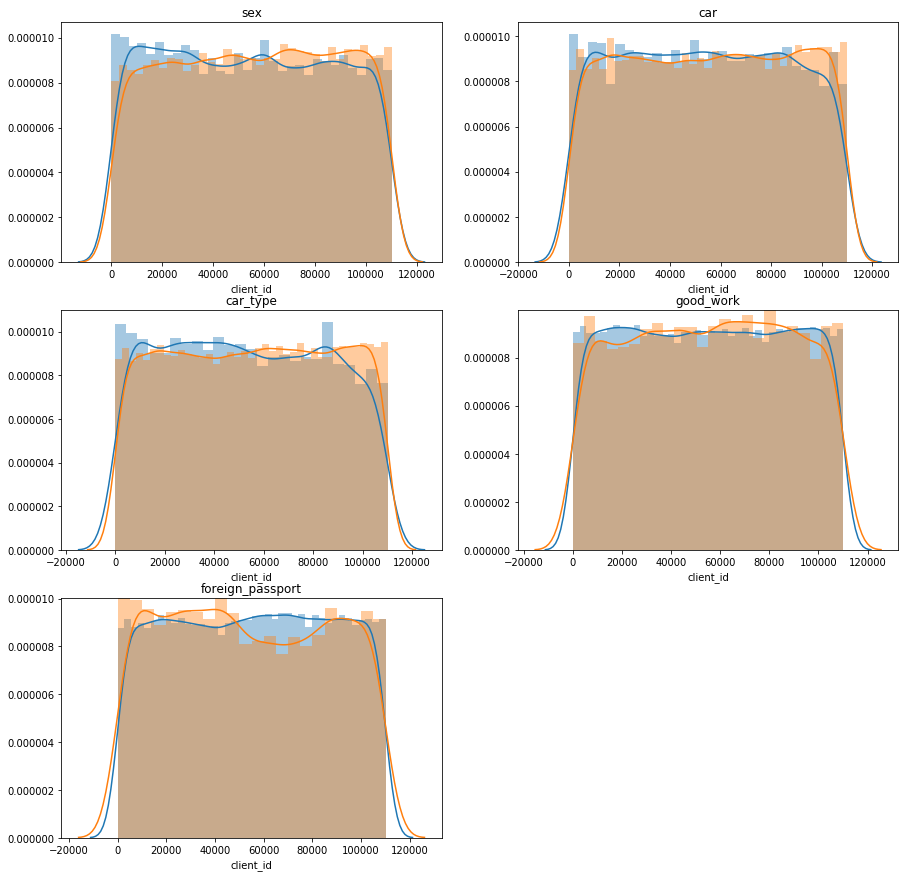

In [137]:
features = bin_cols
column_num = 2
row_num = len(features)//column_num+1

plt.figure(figsize=(15,5*row_num))
for i,column in enumerate(features):
    categories = data[column].unique()
    plt.subplot(row_num,column_num,i+1)
    sns.distplot(data.loc[data[column]==categories[0]].client_id)
    sns.distplot(data.loc[data[column]==categories[1]].client_id)
    plt.title(column)
plt.show()




C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes

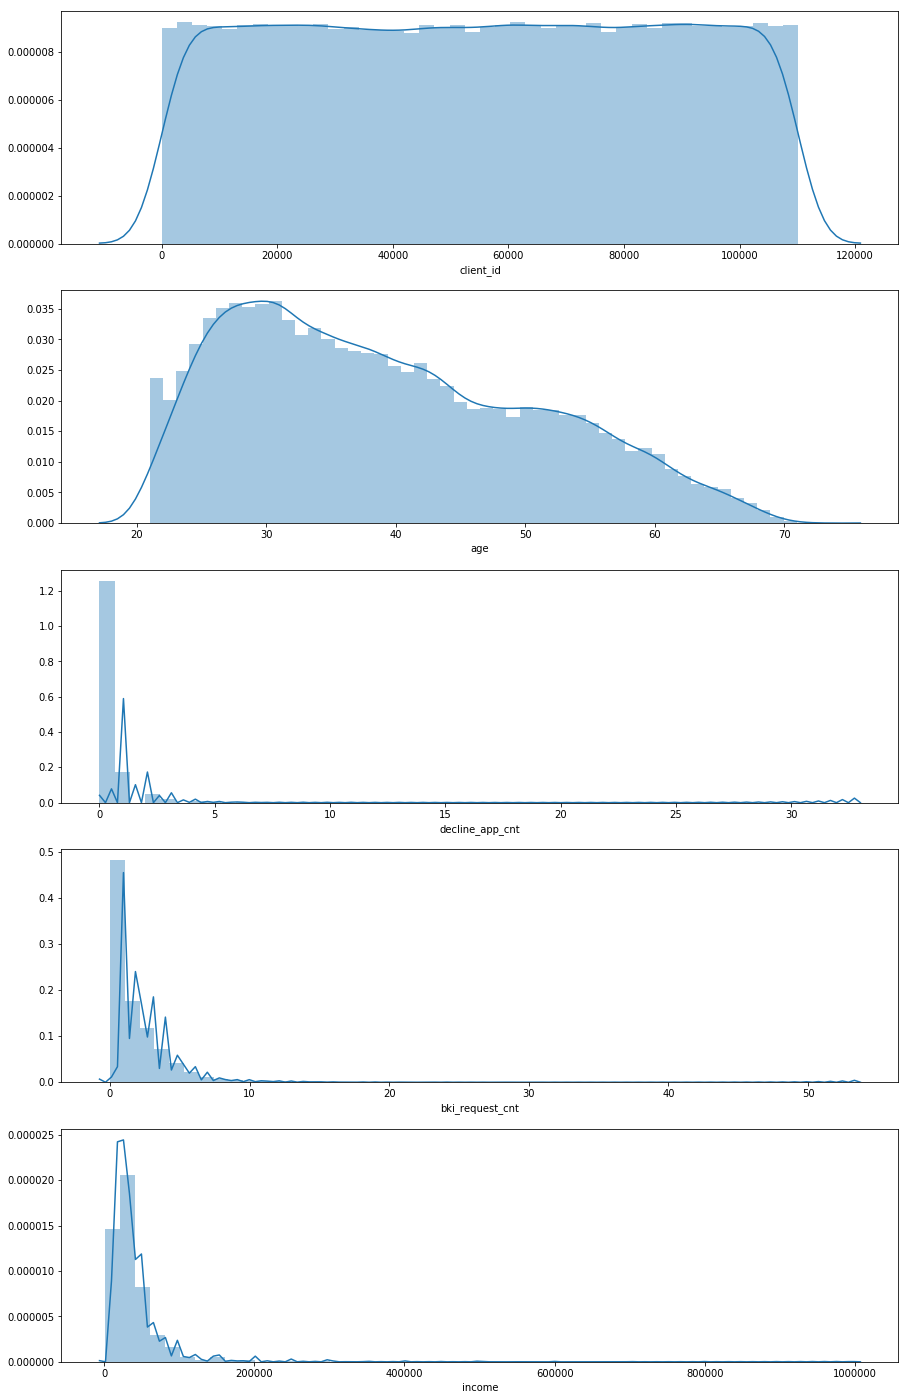

In [128]:
features = num_cols
column_num = 1
row_num = len(features)//column_num+1

plt.figure(figsize=(15,5*row_num))
for i,column in enumerate(features):
    plt.subplot(row_num,column_num,i+1)
    sns.distplot(data[column])
plt.show()

In [130]:
data.income.value_counts().sort_index()

1000         5
1100         1
1500         2
1700         1
2000         1
2400         2
2450         1
2500         1
3000         4
3073         1
3500         2
3700         1
3800         1
4000         9
4500         4
4646         1
4800         1
4900         2
4980         1
5000       527
5100         2
5200        18
5280         1
5300         6
5400         5
5500        25
5555         1
5600        10
5650         2
5660         1
          ... 
426000       1
430000       2
450000      11
470000       1
480000       2
500000      54
507000       1
510000       1
520000       1
522000       1
530000       1
550000       6
580000       1
600000      20
630000       1
650000       2
680000       1
700000      13
750000       1
765000       1
800000       8
830000       1
850011       1
900000       6
947000       1
950000       4
990000       1
999000       2
999999       3
1000000     10
Name: income, Length: 966, dtype: int64

## ПОДВАЛ

In [44]:
default_by_id = pd.Series(data.default.tolist(),index = data.client_id.tolist()) 